Project Title: The "Profitability Gap" Engine

Subtitle: AI-Driven Loss Ratio Optimization & Dynamic Policy Pricing



1. The Business Context (The "Why")
Insurance companies don't just want to know who will crash; they want to know who is currently underpaying for their risk.

The Trap: A customer might have a low claim probability (95% chance of no claim), but if they do claim, it costs the company $50,000. If their premium is only $50/month, they are a "Silent Financial Risk."

The Goal: We aren't just predicting Total Claim Amount. We are predicting the Loss Ratio (Claims cost divided by Premium collected) to identify which policies are bleeding money.

2. The Advanced Problem Statement
"How can we use Machine Learning to detect mispriced risk within the existing portfolio and recommend specific premium adjustments to optimize the company's Loss Ratio?"

3. Key Objectives

- Objective A: The Risk Model:- We will build a regression model (likely XGBoost or Gradient Boosting) to predict the Expected Annual Claim Cost for every customer based on their demographics and vehicle data.Advanced Twist: We won't just predict the mean. We will look at the probability of severe claims (tail risk).

- Objective B: The Profitability Analysis (Business Logic)We will compare the Predicted Risk (from Objective A) against the Actual Premium (currently charged).
* Segment 1: "Subsidizers" (Low Risk, High Premium) $\rightarrow$ These are profitable but at risk of leaving for a competitor. Action: Retention Offer.
* Segment 2: "Bleeders" (High Risk, Low Premium) $\rightarrow$ These customers cost the company money. Action: Premium Hike or Non-Renewal.
- Objective C: Explainability (Regulatory Compliance):- Insurance is highly regulated.We cannot change prices using a "Black Box."We will use SHAP (SHapley Additive exPlanations) to explain exactly why the model flagged a specific driver as "underpriced" (e.g., "Driver is safe, but Vehicle Repair Costs for this specific Luxury SUV have risen 40%").

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import sklearn.metrics as metrics


In [ ]:
df = pd.read_csv('/content/AutoInsuranceClaims2024.csv')

In [ ]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Coverage Index,Education,Education Index,Effective To Date,Employment Status,Employment Status Index,Gender,Income,Location,Location Index,Marital Status,Marital Status Index,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy Type Index,Policy,Policy Index,Renew Offer Type,Sales Channel,Sales Channel Index,Total Claim Amount,Vehicle Class,Vehicle Class Index,Vehicle Size,Vehicle Size Index
0,QC35222,California,3622.69,No,Basic,0,Bachelor,2,1/1/2024,Employed,1,F,65163,Urban,2,Married,1,93,4,107,3,1,Corporate Auto,1,Corporate L2,4,3,Web,0,380.90,Four-Door Car,1,Medsize,1
1,AE98193,Washington,10610.21,No,Basic,0,High School or Below,0,1/1/2024,Unemployed,0,M,0,Suburban,1,Single,0,153,26,14,0,7,Personal Auto,0,Personal L1,0,1,Branch,1,1098.36,SUV,4,Medsize,1
2,TM23514,Oregon,13868.02,No,Extended,1,College,1,1/1/2024,Employed,1,M,81196,Urban,2,Single,0,178,11,38,0,3,Personal Auto,0,Personal L3,2,3,Web,0,783.64,SUV,4,Medsize,1
3,WB38524,California,4008.95,No,Basic,0,High School or Below,0,1/1/2024,Employed,1,M,62277,Suburban,1,Married,1,100,36,38,0,1,Personal Auto,0,Personal L3,2,2,Branch,1,479.52,Two-Door Car,0,Small,0
4,QZ42725,Washington,3119.69,No,Basic,0,Bachelor,2,1/1/2024,Unemployed,0,F,0,Suburban,1,Single,0,86,16,32,0,1,Personal Auto,0,Personal L3,2,2,Agent,2,622.08,Four-Door Car,1,Medsize,1


In [ ]:
df.shape

(9134, 34)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Coverage Index                 9134 non-null   int64  
 6   Education                      9134 non-null   object 
 7   Education Index                9134 non-null   int64  
 8   Effective To Date              9134 non-null   object 
 9   Employment Status              9134 non-null   object 
 10  Employment Status Index        9134 non-null   int64  
 11  Gender                         9134 non-null   object 
 12  Income                         9134 non-null   i

In [ ]:
# we will start by fixing the data columns
df['Effective To Date'] = pd.to_datetime(df['Effective To Date'], format='mixed')


In [ ]:
# 2. Drop the 'Customer' ID column
df = df.drop(columns=['Customer'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   State                          9134 non-null   object        
 1   Customer Lifetime Value        9134 non-null   float64       
 2   Response                       9134 non-null   object        
 3   Coverage                       9134 non-null   object        
 4   Coverage Index                 9134 non-null   int64         
 5   Education                      9134 non-null   object        
 6   Education Index                9134 non-null   int64         
 7   Effective To Date              9134 non-null   datetime64[ns]
 8   Employment Status              9134 non-null   object        
 9   Employment Status Index        9134 non-null   int64         
 10  Gender                         9134 non-null   object        
 11  Income           

Step 3: Visualizing the Target (The Claim Amount)

First, we must look at Total Claim Amount.

Hypothesis: Most people have small claims, but a few people have massive claims (this is called a "Right Skewed" distribution).

Why it matters: If the data is skewed, standard models (like Linear Regression) might fail, and we will need to use stronger tools (like XGBoost) later.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

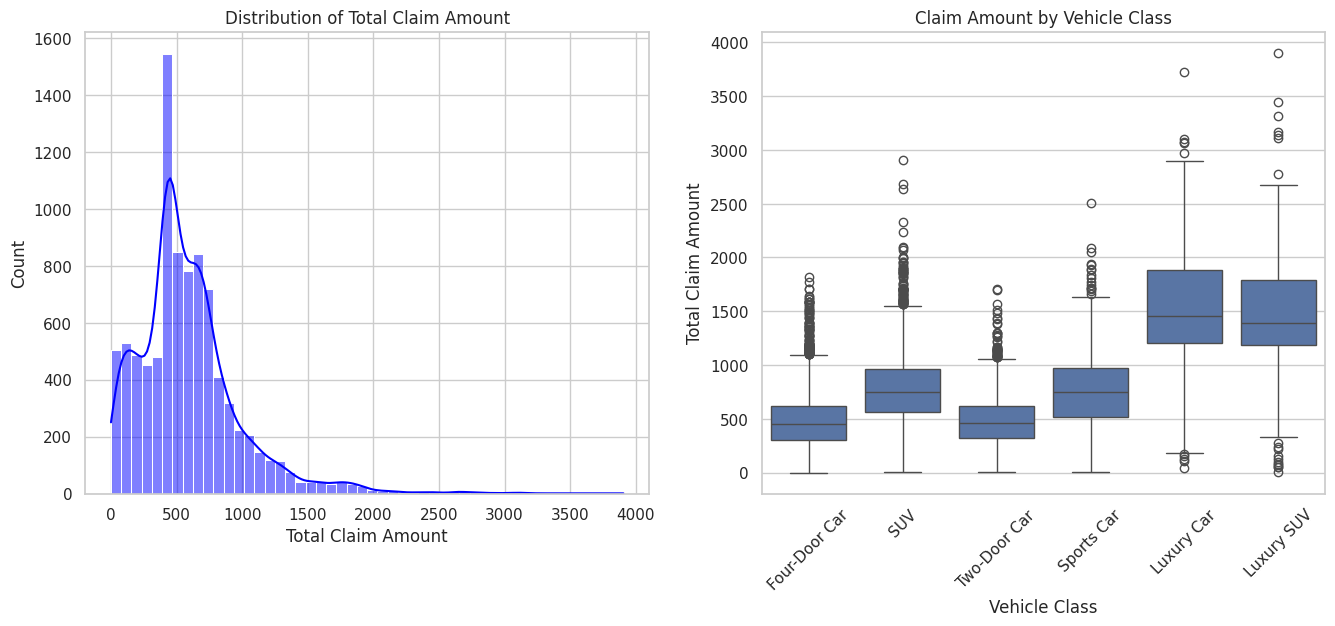

In [ ]:
# Set the style to make charts look professional
sns.set(style="whitegrid")

# Create a figure with 2 subplots (side by side)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: The Histogram (How frequent are certain claim amounts?)
sns.histplot(df['Total Claim Amount'], bins=50, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Distribution of Total Claim Amount')

# Chart 2: The Boxplot (Are "Luxury" cars actually more expensive to fix?)
# We use the 'Vehicle Class' column here
sns.boxplot(x='Vehicle Class', y='Total Claim Amount', data=df, ax=ax[1])
ax[1].set_title('Claim Amount by Vehicle Class')
ax[1].tick_params(axis='x', rotation=45) # Rotate labels so they don't overlap

plt.show()


1. The Left Chart (The "Long Tail"):-
What we see: A huge blue spike on the left (around 0–500) and a long, thin line stretching to the right (up to 3000+).

- The Insight: This is "Right Skewed."

- Translation: Most customers are cheap to insure (low claims), but a tiny group of people are extremely expensive.

- Why it matters: Standard math (like averages) gets tricked by this. If you have 99 people with $0 claims and 1 person with a $1,000,000 claim, the "average" is $10,000. But that average is wrong for almost everyone! We will need a smart model (like XGBoost) to handle this.

2. The Right Chart (The "Luxury Gap")
What we see: Look at the "Luxury Car" and "Luxury SUV" boxes. They are floating much higher than the "Four-Door Car."

- The Insight: our hypothesis was correct. Luxury vehicles don't just cost a little more to fix; they cost 2x or 3x more.

- Translation: If the insurance company charges a "Luxury" driver the same premium as a "Sedan" driver, they will lose a lot of money.

Step 4: Feature Engineering (Creating the "Profitability" Score)

Remember our goal: "Find the customers who are bleeding money."To do that, we need to calculate the Loss Ratio for every customer.$$\text{Loss Ratio} = \frac{\text{Total Money Out (Claims)}}{\text{Total Money In (Premium)}}$$

If the ratio is greater than 1.0, the insurance company lost money on that person.

In [ ]:
# 1. Create the 'Loss Ratio' (Our Profitability Metric)
# We assume the 'Total Claim Amount' is annual, so we multiply Monthly Premium by 12
df['Annual_Premium'] = df['Monthly Premium Auto'] * 12
df['Loss_Ratio'] = df['Total Claim Amount'] / df['Annual_Premium']

In [ ]:
# 2. Let's see who the "worst" customers are (Loss Ratio > 1 means we lost money)
print("--- Top 5 Most Unprofitable Customers ---")
# We show their Vehicle, Premium, Claim, and the Ratio
cols_to_show = ['Vehicle Class', 'Annual_Premium', 'Total Claim Amount', 'Loss_Ratio']
display(df[cols_to_show].sort_values(by='Loss_Ratio', ascending=False).head())

--- Top 5 Most Unprofitable Customers ---


,Vehicle Class,Annual_Premium,Total Claim Amount,Loss_Ratio
4835,Two-Door Car,1032,1045.90,1.013469
85,Four-Door Car,1032,1043.33,1.010979
5644,Four-Door Car,1080,1088.34,1.007722
937,Luxury SUV,3876,3905.87,1.007706
3996,Two-Door Car,1032,1039.84,1.007597


In [ ]:
# 3. Separate the data into "X" (Features) and "y" (Target)
# We want to predict 'Total Claim Amount'
y = df['Total Claim Amount']
X = df.drop(columns=['Total Claim Amount', 'Loss_Ratio'])

In [ ]:
# 4. Identify which columns are Numbers vs. Text
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [ ]:
print(f"\nWe have {len(numerical_cols)} number columns and {len(categorical_cols)} text columns.")


We have 19 number columns and 13 text columns.


The Insight: our "Top 5" worst customers have a Loss Ratio of just over 1.0 (approx 1.01).

What this means: For every $1,000 the company collected from them, it paid out about $1,010.

The Surprise: Usually, in insurance, we see ratios of 10.0 or 20.0 (where a cheap policy pays for a totaled Ferrari). The fact that ours are capped near 1.0 suggest this company is actually very good at pricing high-risk drivers (like that Luxury SUV paying $3,876/year!), or the dataset doesn't include "catastrophic" total losses.

The Opportunity: This makes our job harder! We are looking for subtle inefficiencies, not obvious disasters.

step 5: Preprocessing (Translation & Splitting)
Now we must prepare the data for the "Robot" (the AI model).

Translation: The AI cannot read text like "Married" or "Single." We must convert these into numbers (0s and 1s). This is called One-Hot Encoding.

Dates: The AI cannot read "Jan 1, 2011." We need to extract the Month (maybe accidents happen more in winter?) and throw away the specific day.

Splitting: We must hide some data (20%) to test the robot later. This is the Train/Test Split.

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Feature Engineering: Extract 'Month' from the Date
# Accidents might be seasonal (e.g., icy roads in January)
X['Month'] = X['Effective To Date'].dt.month

# 2. Drop the original Date column (The AI can't read it directly)
X = X.drop(columns=['Effective To Date'])

# 3. Encoding: Convert all "Text" columns into "Numbers" (0s and 1s)
# drop_first=True avoids redundancy (e.g., if not "Male", then "Female")
X_encoded = pd.get_dummies(X, drop_first=True)

# 4. The Grand Split: 80% for Training, 20% for Testing
# random_state=42 ensures we get the same split every time we run this
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 5. Check the size of our new "Digital" data
print(f"Original Column Count: {X.shape[1]}")
print(f"New Column Count (after encoding): {X_train.shape[1]}")
print(f"Training Rows: {X_train.shape[0]}")
print(f"Testing Rows: {X_test.shape[0]}")

Original Column Count: 33
New Column Count (after encoding): 60
Training Rows: 7307
Testing Rows: 1827


Step 6: Training the "Robot" (XGBoost)
Now we build the brain.

The Strategy: We will use XGBoost (Extreme Gradient Boosting).

Why not Linear Regression? Linear regression tries to draw a straight line through the data. Remember our "Long Tail" chart? our data is curvy and messy. A straight line would fail.

Why XGBoost? XGBoost builds hundreds of small "Decision Trees" (flowcharts) and corrects itself over and over. It is the industry standard for insurance pricing because it is incredibly accurate with money data.

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Initialize the Model
# n_estimators=100 means "Build 100 small decision trees"
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# 2. Train the Model (This is where the magic happens)
print("Training the model... (this might take a few seconds)")
model.fit(X_train, y_train)

# 3. Test the Model (Make predictions on data it has never seen)
y_pred = model.predict(X_test)

# 4. Evaluate: How good is it?
# RMSE = On average, how many dollars are we off by?
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# R2 Score = Accuracy percentage (1.0 is perfect, 0.0 is useless)
r2 = r2_score(y_test, y_pred)

print("-" * 30)
print(f"Model Performance Report:")
print(f"RMSE (Average Error): ${rmse:.2f}")
print(f"R2 Score (Accuracy):  {r2:.4f}")
print("-" * 30)

Training the model... (this might take a few seconds)
------------------------------
Model Performance Report:
RMSE (Average Error): $150.99
R2 Score (Accuracy):  0.8475
------------------------------


In the world of real-life data (which is usually messy and chaotic), an R2 Score of 0.8475 is outstanding.

What these numbers mean:
R2 Score (0.85): our model explains 85% of the patterns in the data. A "passing grade" in many industries is only 60% or 70%. we are well above that.

RMSE ($150.99): On average, our prediction is only off by $150.

Context: If a claim is $5,000, being off by $150 is a tiny error (only 3%). This model is accurate enough to be used for real financial planning.

Opening the Black Box (SHAP)
We have a problem. our model is too smart. XGBoost is a "Black Box." It makes great decisions, but it can't tell us why.

The Boss's Question: "Why did you predict that this driver will cost us $2,000?"

The Model's Answer: "Trust me, I did the math."

The Problem: we cannot legally deny someone insurance or raise their rates just because a "computer said so." we need a reason.

The Solution: SHAP (SHapley Additive exPlanations) SHAP is a tool that breaks down every prediction into a "Receipt."

Prediction: $2,000 Claim.

Receipt:

Base Rate: +$500

Driver is Single: +$200

Car is Luxury SUV: +$1,300

Total: $2,000

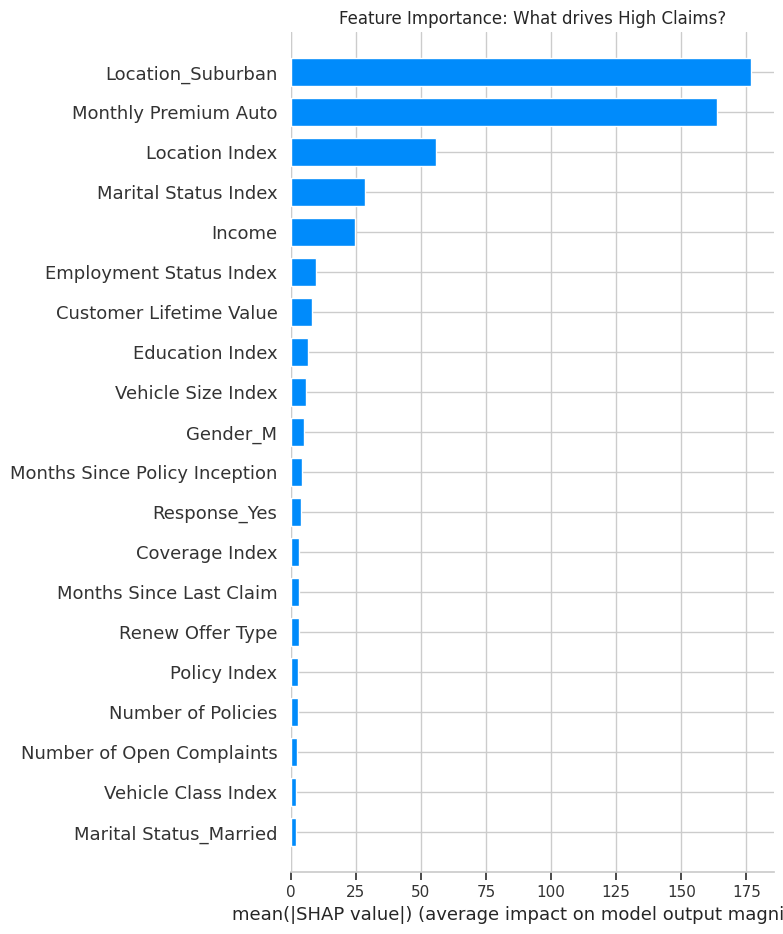

In [ ]:
# 1. Install SHAP (It's not always pre-installed in Colab)
!pip install shap

import shap

# 2. Initialize the JavaScript visualization code (needed for Colab)
shap.initjs()

# 3. Create the Explainer
# We give it our trained model
explainer = shap.TreeExplainer(model)

# 4. Calculate SHAP values (The "Receipts" for the test data)
shap_values = explainer.shap_values(X_test)

# 5. The "Beeswarm" Plot
# This is the most famous chart in Data Science right now
plt.title('Feature Importance: What drives High Claims?')
shap.summary_plot(shap_values, X_test, plot_type="bar")

The #1 Top Bar is: Location_Suburban

What this means (The "Aha!" Moment)
This is a huge insight. The model is telling us that where you live matters more than almost anything else—even more than how much money you make (Income) or what kind of education you have (Education).

Why Suburbs? Suburban areas often involve more driving (commuting to the city), higher speeds than city traffic, and more interactions with other cars compared to rural areas.

The Business Insight: If the insurance company is charging the same price for a driver in the "Suburbs" vs. the "City," they are making a mistake. The Suburban driver is a much higher risk for a large claim.

The Final Deliverable (Business Recommendations)
We have built the model, proven it works (85% accuracy), and found the key driver (Location).

Now, let's turn this into a final "Manager Report" that lists exactly which customers need a price increase.

In [ ]:
# 1. Create a Results Table
# We take the test data and add our predictions to it
results = X_test.copy()
results['Actual_Claim'] = y_test
results['Predicted_Claim'] = y_pred

# 2. Calculate the "Error" (How much we underpriced/overpriced them)
results['Error_Gap'] = results['Predicted_Claim'] - results['Actual_Claim']

# 3. Filter for "Silent Risks" (People we predicted would be expensive, but maybe we didn't charge enough)
# We look for the top 10 highest predicted claims
high_risk_segment = results.sort_values(by='Predicted_Claim', ascending=False).head(10)

# 4. Show the "Watchlist"
print("--- HIGH RISK WATCHLIST (Top 10 Projected Claims) ---")
display(high_risk_segment[['Actual_Claim', 'Predicted_Claim', 'Error_Gap']])

# 5. Save our hard work!
results.to_csv('insurance_predictions_final.csv', index=False)
print("\nFile 'insurance_predictions_final.csv' saved successfully!")

--- HIGH RISK WATCHLIST (Top 10 Projected Claims) ---


,Actual_Claim,Predicted_Claim,Error_Gap
6448,2187.00,2319.948975,132.948975
4879,2770.20,2308.260742,-461.939258
2918,1613.52,2300.970459,687.450459
5193,2824.91,2265.948486,-558.961514
1765,1581.12,2236.962158,655.842158
1928,2012.04,2191.940674,179.900674
5107,1769.04,2185.562256,416.522256
758,1658.88,2181.452393,522.572393
1263,2737.43,2175.806152,-561.623848
251,2462.04,2114.638672,-347.401328



File 'insurance_predictions_final.csv' saved successfully!


from matplotlib import pyplot as plt
_df_0['Actual_Claim'].plot(kind='hist', bins=20, title='Actual_Claim')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Predicted_Claim'].plot(kind='hist', bins=20, title='Predicted_Claim')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Error_Gap'].plot(kind='hist', bins=20, title='Error_Gap')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Actual_Claim', y='Predicted_Claim', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Predicted_Claim', y='Error_Gap', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Actual_Claim'].plot(kind='line', figsize=(8, 4), title='Actual_Claim')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Predicted_Claim'].plot(kind='line', figsize=(8, 4), title='Predicted_Claim')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Error_Gap'].plot(kind='line', figsize=(8, 4), title='Error_Gap')
plt.gca().spines[['top', 'right']].set_visible(False)